<a href="https://colab.research.google.com/github/lapidesd/wetted_channels_from_space/blob/main/Colab_notebooks/wetted_channel_random_forest_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Initial data preparation

In [1]:
# import required packages
import pandas as pd
# !pip install pandas fiona shapely pyproj rtree
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
!pip install rasterio
import rasterio
from rasterio.plot import show

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 5.7 MB/s 
     |████████████████████████████████| 6.3 MB 53.2 MB/s 
     |████████████████████████████████| 1.0 MB 49.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 392 kB/s 


In [7]:
jsonfiles = ['Streamchannels_R2_2015_Rock.geojson',
 'Streamchannels_R2_2015_Hank.geojson',
 'Streamchannels_R2_2015_Dry.geojson',
 'Streamchannels_R1_2015_Rock.geojson',
 'Streamchannels_R1_2015_Hank.geojson',
 'Streamchannels_R1_2015_Confluence.geojson',
 'Streamchannels_R1_2015_Dry.geojson',
 '2015_map_paths_R1.geojson',
 '2015_map_paths_R2.geojson',
 'Streamchannels_R2_2015_Confluence.geojson']

In [8]:
# import data files
geodata = {f:0 for f in jsonfiles}
for f in jsonfiles:
  print(f)
  df = gpd.read_file('https://raw.githubusercontent.com/lapidesd/'+
                     'wetted_channels_from_space/main/Data/'+f)
  geodata[f] = df

# geomorphic channel points
geomorph = pd.read_csv('https://raw.githubusercontent.com/lapidesd/wetted_channels_from_space/'+
                       'main/Data/geomorphic%20channel%20points%201085%20with%20xy%20and%20flowaccum.csv')
geomorph = gpd.GeoDataFrame(
    geomorph, geometry=gpd.points_from_xy(geomorph.x, geomorph.y)).set_crs('EPSG:4326')

# wetted channel surveys
surveyR1 = pd.concat([geodata['Streamchannels_R1_2015_'+key] for key in 
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
surveyR2 = pd.concat([geodata['Streamchannels_R2_2015_'+key] for key in 
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])

# paths traversed during wetted channel surveys
pathR1 = geodata['2015_map_paths_R1.geojson']
pathR2 = geodata['2015_map_paths_R2.geojson']


Streamchannels_R2_2015_Rock.geojson
Streamchannels_R2_2015_Hank.geojson
Streamchannels_R2_2015_Dry.geojson
Streamchannels_R1_2015_Rock.geojson
Streamchannels_R1_2015_Hank.geojson
Streamchannels_R1_2015_Confluence.geojson
Streamchannels_R1_2015_Dry.geojson
2015_map_paths_R1.geojson
2015_map_paths_R2.geojson
Streamchannels_R2_2015_Confluence.geojson


In [9]:
# merge lithology data into geomorphic network
gdf = geomorph.to_crs('EPSG:4326')
gdf.drop(columns=[
                  'ARCID',
                  'GRID_CODE','FROM_NODE','TO_NODE','Length',
                  'layer','path',
                  'distance','angle'],inplace=True)
gdf.rename(columns={'Type':'Lithology_Type',
                    'SAMPLE_1':'accum [m2]'},inplace=True)
gdf = gdf.drop_duplicates()

In [10]:
newarea = pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                      'wetted_channels_from_space/main/Data/'+
                      'geomorphic_pts_newarea%202.csv')[['x','y','area_updated','slope_percent']]
gdf_save = gdf.reset_index().merge(newarea,left_on=['x','y'],
                        right_on=['x','y'])

# # uncomment to save
# gdf_save.drop(columns=['accum [m2]',]).rename(columns={'index':'unique_id'}).to_csv('/content/drive/MyDrive/Sky_Data/unique_id.csv')

# Put together a dataset of nodes with RapidEye data
This cannot be run in Colab (would take days), and RapidEye data is not available in the data supplement

In [ ]:
# # connect to google drive
# from google.colab import drive
# drive.mount('/content/drive')

# rasters = os.listdir('/content/drive/MyDrive/Sky_Data/RapidEye/apply/')
# rasters = [r for r in rasters if r.endswith('SR_clip.tif')]

In [ ]:
# # function to extract RapidEye zonal stats in buffer (buffer=True)
# # around geomorphic channel
# # or at geomorphic channel point (buffer=False)
# def query_raster(x,y, point1, raster, buffer):  
#     r=raster
#     band_data = {'blue':0,
#                    'geometry':0,
#                    'green':0,
#                    'red':0,
#                    'rededge':0,
#                    'NIR':0,
#                  'missing':0}
#     missing = 0
#     row, col = r.index(x,y)
#     if buffer:
#       rs = list(range(row-1,row+2))
#       cs = list(range(col-1,col+2))
#     else:
#       rs = [row]
#       cs = [col]
#     try:
#       blues = []
#       greens = []
#       reds = []
#       rededges = []
#       nirs = []
#       for row in rs:
#         for col in cs:
#           blues.append(raster.read(1)[row,col])
#           greens.append(raster.read(2)[row,col])
#           reds.append(raster.read(3)[row,col])
#           rededges.append(raster.read(4)[row,col])
#           nirs.append(raster.read(5)[row,col])
      
#       band_data['blue'] = np.nanmean(blues)
#       band_data['geometry'] = point1
#       band_data['green'] = np.nanmean(greens)
#       band_data['red'] = np.nanmean(reds)
#       band_data['rededge'] = np.nanmean(rededges)
#       band_data['NIR'] = np.nanmean(nirs)
#     except:
#       missing = 1
#     band_data['missing'] = missing
#     return (band_data)

In [ ]:
# very slow in colab--ran on local machine

# # gdfs = []
# !pip install multiprocess
# gdf['x'] = gdf.to_crs('EPSG:32610').geometry.x
# gdf['y'] = gdf.to_crs('EPSG:32610').geometry.y
# import rasterio
# def buffer(args):
#     cpu,cpus,rasters = args
#     for i in range(int(cpu/cpus*len(rasters)),int((cpu+1)/cpus*len(rasters))):
#         r1 = rasters[i]
#         #   print(i,'of',len(rasters))
#         date = r1.split('_')[1]
#         r = rasterio.open('/content/drive/MyDrive/Sky_Data/RapidEye/apply/'+r1)
        
#         out = gdf.apply(lambda row:query_raster(row.x,row.y,row.geometry,
#                                                                      r,buffer = True),axis=1)  
#         keys = list(out.values[0].keys())
#         band_data = pd.DataFrame.from_dict({keys[j]:[out.values[i][keys[j]] for i in range(len(out))]
#                               for j in range(len(keys))})
#         band_data = gpd.GeoDataFrame(
#           band_data, geometry=band_data.geometry).set_crs('EPSG:4326')
#         band_data['NDWI'] = (band_data.green-band_data.NIR)/(band_data.green+band_data.NIR)
#         g = gpd.sjoin(band_data,gdf,how='left')   
#         g = g.drop_duplicates().drop(columns='index_right')
#         g['date'] = date
#         g.to_file('/content/drive/MyDrive/Sky_Data/RapidEye/buffer_data1/'+r1[:-4]+'.tif')
#     return

# import multiprocess as mp
# import sys


# cores = 8
# sys.stdout.write('\r\n')
# arguments = []
# for cpu in range(0,cores):
#     arguments.append((cpu,cores,rasters))
# pool = mp.Pool()
# results = pool.map(buffer, arguments)

In [ ]:
# gdfs = []
# for i in range(len(rasters)):
#     r = rasters[i]
#     print(i,' of',len(rasters))
#     g = gpd.read_file('buffer_data1/'+r[:-4]+'.tif/'+r[:-4]+'.shp')
#     gdfs.append(g)

In [ ]:
# gdf_predict['x'] = gdf_predict.geometry.x
# gdf_predict['y'] = gdf_predict.geometry.y
# gdf_predict.to_csv('buffer_data/rapideye_predict_data_buffer.csv')

# Put together a dataset for training the random forest model

In [11]:
# 0 dry
# 1 flowing
# 2 possibly wet, unobserved
# 3 likely wet, not observed round 1
# 4 wet, stagnant
# 5 wet in round 1 but dry in round 2

wetsymbols1 = [1,2,3,4,5]
wetsymbols2 = [1,2,3,4]

# if point is assigned to wet and dry, assume wet

# find points marked as wet during survey R1
surveyR1 = pd.concat([geodata['Streamchannels_R1_2015_'+key] for key in 
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
# surveyR1wet = surveyR1[surveyR1.moisture.isin(wetsymbols1)]
surveyR1['geometry'] = surveyR1.buffer(1.5)
R1_wet = gpd.sjoin(gdf,surveyR1.to_crs('EPSG:4326')).drop(columns=['Length',])
gdf1 = gpd.sjoin(R1_wet[['geometry','Moisture']],gdf,how='right').fillna(0)
gdf1['wet'] = np.where(gdf1.Moisture.isin(wetsymbols1),1,0)
gdf1 = gdf1.drop_duplicates()
gdf1['wet'] = np.where(gdf1.drop(columns=['wet','Moisture']).duplicated(keep=False),1,gdf1.wet)
gdf1 = gdf1[~(gdf1.drop(columns=['Moisture','wet']).duplicated(keep='first'))]
gdf1.drop(columns=['index_left','Moisture'],inplace=True)
# Date of nearest RapidEye image
gdf1['date'] = pd.to_datetime('2015-06-04')


# find points marked as wet during survey R2
surveyR2 = pd.concat([geodata['Streamchannels_R2_2015_'+key] for key in 
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
# surveyR2wet = surveyR2[surveyR2.moisture.isin(wetsymbols2)]
surveyR2['geometry'] = surveyR2.buffer(1.5)
R2_wet = gpd.sjoin(gdf,surveyR2.to_crs('EPSG:4326')).drop(columns=['Length',])
gdf2 = gpd.sjoin(R2_wet[['geometry','Moisture']],gdf1,how='right').fillna(0)
gdf2['wet'] = np.where(gdf2.Moisture.isin(wetsymbols2),1,0)
gdf2 = gdf2.drop_duplicates()
gdf2['wet'] = np.where(gdf2.drop(columns=['wet','Moisture']).duplicated(keep=False),1,gdf2.wet)
gdf2 = gdf2[~(gdf2.drop(columns=['Moisture','wet']).duplicated(keep='first'))]
gdf2.drop(columns=['index_left','Moisture'],inplace=True)

# Date of nearest RapidEye image
gdf2['date'] = pd.to_datetime('2015-08-22')



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [ ]:
testing = []
for i in range(11):
  testing.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                                 'wetted_channels_from_space/main/Data/'+
                                 'predict_data_'+str(i)+'.csv'))
testing = pd.concat(testing)

In [ ]:
gdf1 = gdf1.drop(columns=['date','geometry']).merge(testing[testing.date=='2015-06-04'],left_on=['x','y'],
           right_on=['x','y']).drop_duplicates()

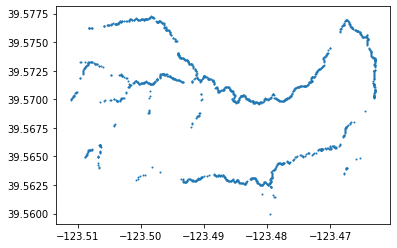

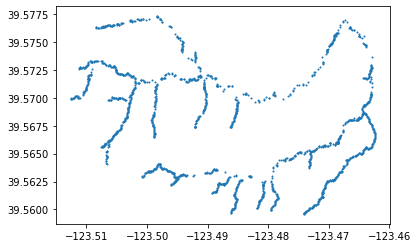

In [ ]:
g1 = gdf1[(gdf1['wet']==1)&(gdf1.area_updated>100000)]
g2 = gdf1[(gdf1['wet']==0)&(gdf1.area_updated>100000)]
plt.scatter(g1.x,g1.y,s=1)
plt.show()
plt.scatter(g2.x,g2.y,s=1
            )

In [ ]:
gdf2 = gdf2.drop(columns=['date','geometry']).merge(testing[testing.date=='2015-08-22'],left_on=['x','y'],
                  right_on=['x','y'])

In [ ]:
gdf3 = testing[testing.date=='2019-10-31']
gdf['wet'] = 0

In [ ]:
gdf4 = testing[testing.date=='2016-03-23']
gdf['wet'] = 1

In [ ]:
gdf5 = testing[testing.date=='2016-03-07']
gdf['wet'] = 1

In [ ]:
gdf6 = testing[testing.date=='2017-01-24']
gdf['wet'] = 1

In [ ]:
gdf_all = pd.concat([gdf1,gdf2,gdf3,gdf4,gdf5,gdf6]).drop(columns=['accum [m2]']).rename(
                                                         columns={'datetime_x':'datetime',
                                                                  'slope_percent_x':'slope_percent'}).fillna(0)
gdf_all.to_csv('/content/drive/MyDrive/Sky_Data/combined_data_buffer.csv')

# Part 2: processing initial data

In [ ]:
# # save original training data to github small size
# # keep this block

# training1 = training.drop(columns=['Unnamed: 0','Lithology_'])
# len2 = int(len(training1)/2)+2
# for i in range(2):
#   training1.iloc[len2*i:len2*(i+1)+1].to_csv('temporary_training_'+str(i)+'.csv',index=False)

In [27]:
testing = []
for i in range(11):
  testing.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                                 'wetted_channels_from_space/main/Data/'+
                                 'predict_data_'+str(i)+'.csv'))
testing = pd.concat(testing)
testing = testing[~(testing.date.isin(testing))]

training = []
for i in range(2):
  training.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                              'wetted_channels_from_space/main/Data/'+
                              'temporary_training_'+str(i)+'.csv'))
training = pd.concat(training)

In [22]:
newarea = pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                      'wetted_channels_from_space/main/Data/'+
                      'geomorphic_pts_newarea%202.csv')[['x','y','area_updated','slope_percent']]


In [28]:
# add an extra day to the training data (done date)
# no longer relevant since using larger channels only

new_data = testing[testing.date=='2018-02-12']
new_data = new_data[new_data['area_updated']<20000]
new_data['wet'] = 0
new_training = pd.concat([training,new_data])

new_training = new_training.drop_duplicates()

# # save data
# new_training.to_csv('/content/drive/MyDrive/Sky_Data/combined_data_buffer1.csv',index=False)

Add in more training data

In [23]:
!pip install hydrofunctions
import hydrofunctions as hf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 3.7 MB/s 
     |████████████████████████████████| 1.6 MB 8.2 MB/s 


In [31]:
elder = hf.NWIS('11475560',start_date='2015-06-01',end_date='2022-08-01',
                parameterCd = '00060').df().rename(columns={'USGS:11475560:00060:00003':'flow_cfs'})
survey_flow = elder.loc['2015-06-04'].flow_cfs
dates_highflow = [str(t).split('T')[0] for t in elder[elder.flow_cfs>survey_flow*3].index.values]

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11475560&parameterCd=00060&startDT=2015-06-01&endDT=2022-08-01


In [29]:
df_test = testing.copy()
df_train = new_training.copy()                                                    

In [33]:
df_test['date'] = pd.to_datetime(df_test.date)
zero_startyr = df_train[(df_train.date=='2015-06-04') &
         (df_train.wet==0)]
forward_test = df_test[(df_test.date>'2015-06-04') &
        (df_test.date<'2015-08-22') &
        (df_test.x.isin(zero_startyr.x.values)) &
        (df_test.y.isin(zero_startyr.y.values))]
forward_test['wet'] = 0
one_endyr = df_train[(df_train.date=='2015-08-22') &
         (df_train.wet==1)]
back_test = df_test[(df_test.date>'2015-06-04') &
        (df_test.date<'2015-08-22') &
        (df_test.x.isin(one_endyr.x.values)) &
        (df_test.y.isin(one_endyr.y.values))]
back_test['wet'] = 1
one_startyr = df_train[(df_train.date=='2015-06-04') &
         (df_train.wet==1)]
backearly_test = df_test[(df_test.date>'2015-03-15') &
        (df_test.date<'2015-06-04') &
        (df_test.x.isin(one_startyr.x.values)) &
        (df_test.y.isin(one_startyr.y.values))]
backearly_test['wet'] = 1
forward_moresummer = df_test[(pd.to_datetime(df_test.date).dt.month.isin([7,8,9,10])) &
                             (df_test.date.dt.year>2016) &
        (df_test.x.isin(zero_startyr.x.values)) &
        (df_test.y.isin(zero_startyr.y.values))]
forward_moresummer['wet'] = 0

# add more training data for wet times 
# (elder flow at least 3x elder flow at first survey)
reallywet = df_test[(df_test.date.isin(dates_highflow)) &
                    (df_test.x.isin(one_startyr.x.values)) &
                    (df_test.y.isin(one_startyr.y.values))]
reallywet['wet'] = 1



# concatenate all of the new data
added_data = pd.concat([df_train,back_test,forward_test,backearly_test,
                        forward_moresummer,
                        reallywet
                        ])
added_data = added_data.drop_duplicates()

## fix 3-7-2016
added_data = added_data[added_data.date!='2016-03-07']
add_fixed_date = df_test[(df_test.date=='2016-03-07')]
add_fixed_date['wet'] = 1
added_data = pd.concat([added_data,add_fixed_date])

# # save data
# added_data.to_csv('/content/drive/MyDrive/Sky_Data/rapideye_train_data_buffer_moredata.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

##ADD in a plot off all dates of training data

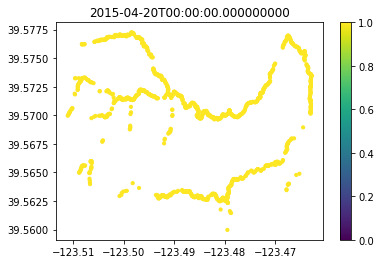

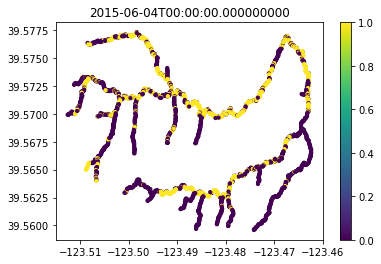

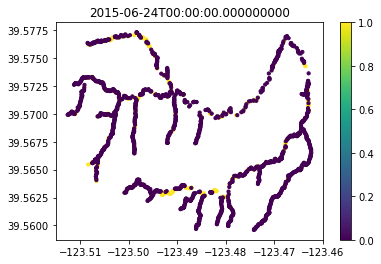

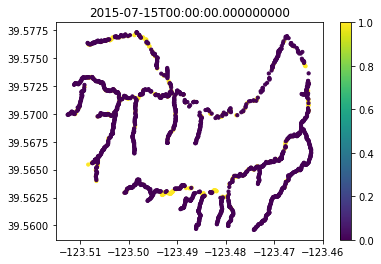

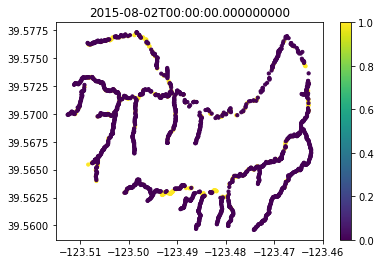

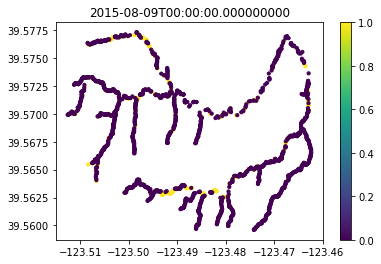

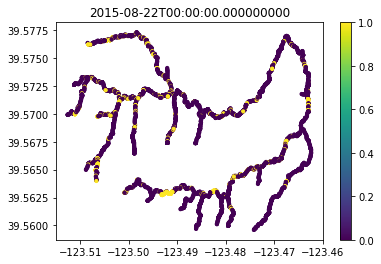

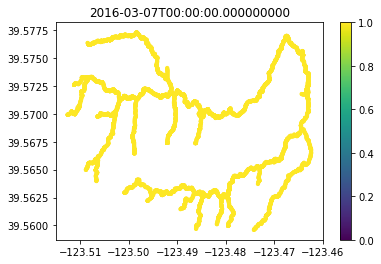

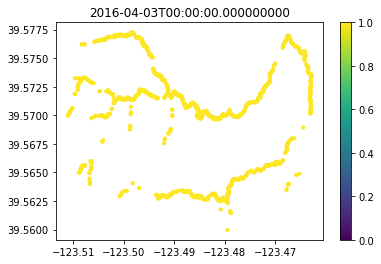

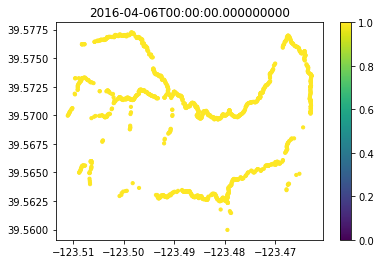

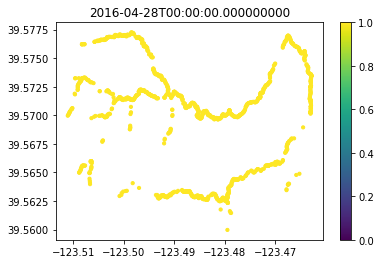

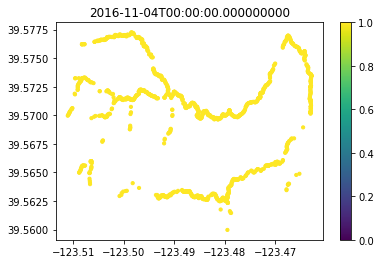

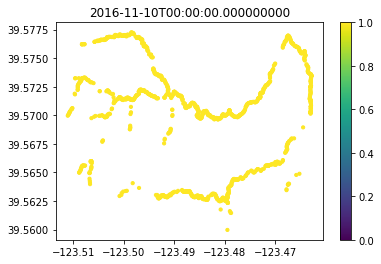

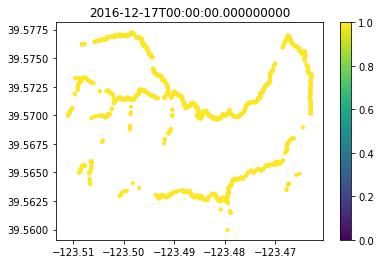

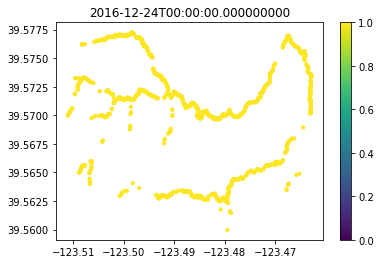

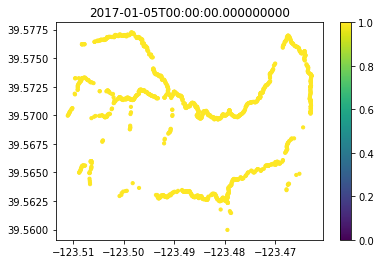

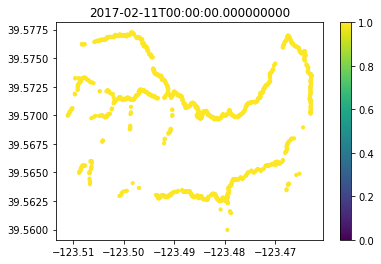

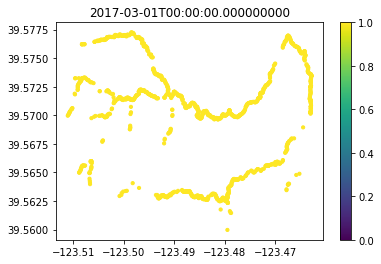

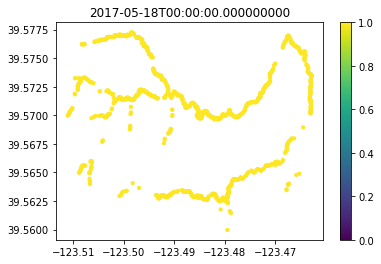

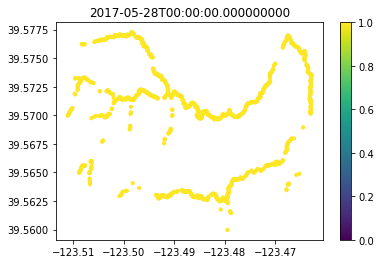

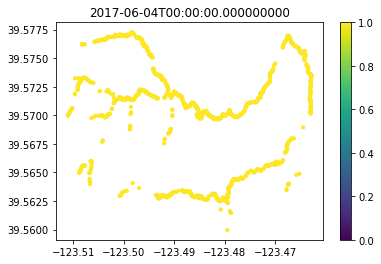

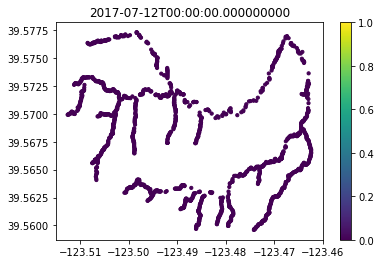

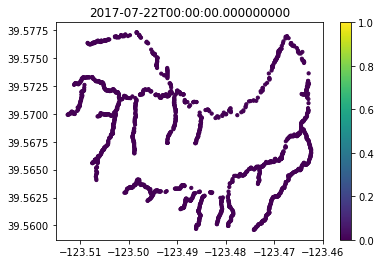

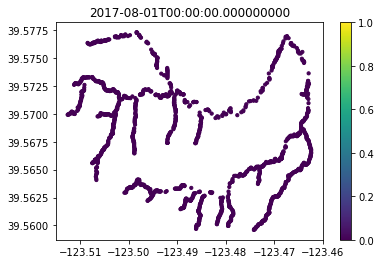

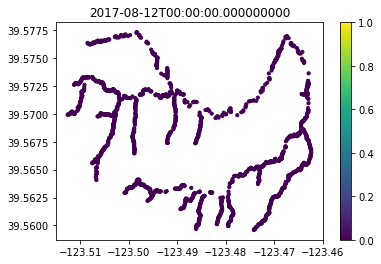

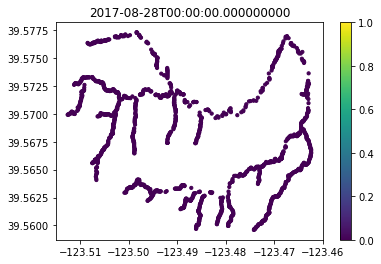

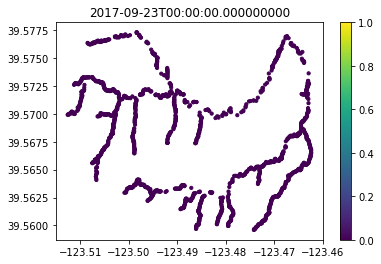

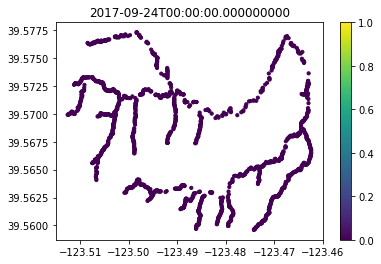

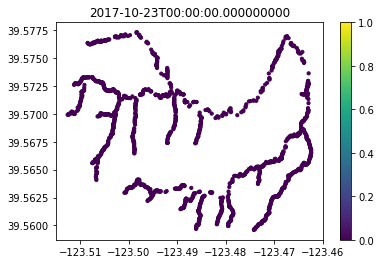

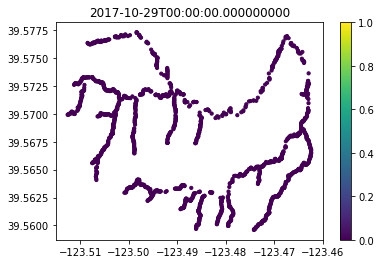

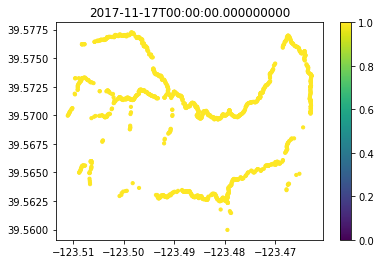

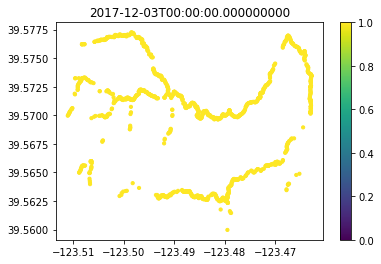

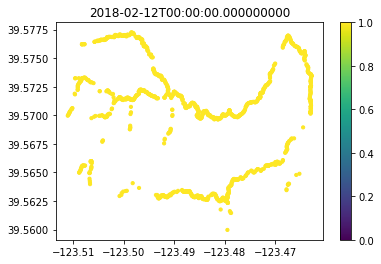

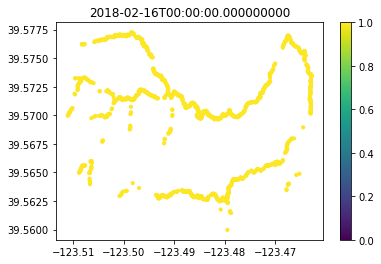

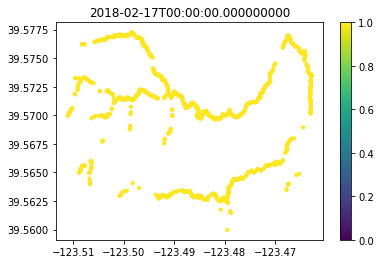

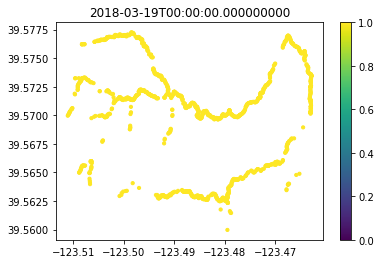

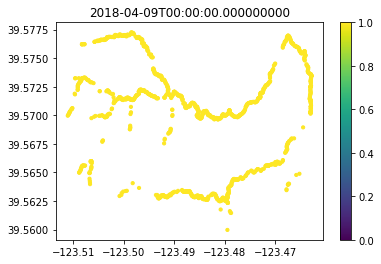

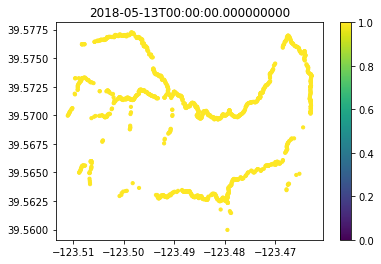

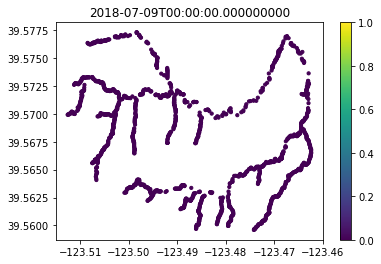

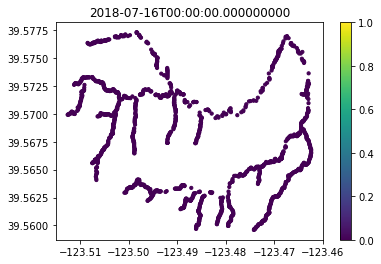

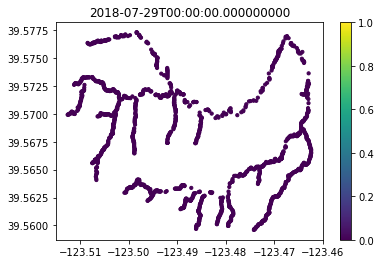

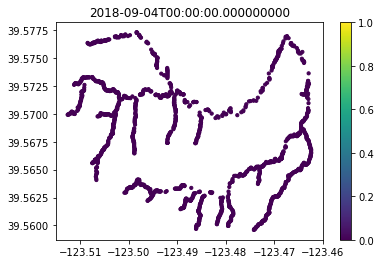

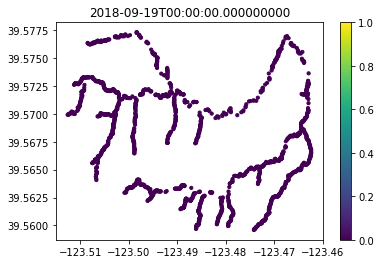

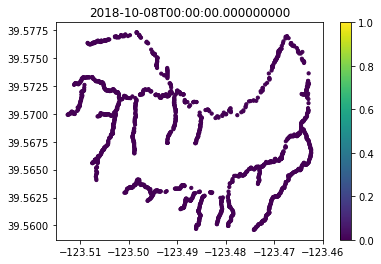

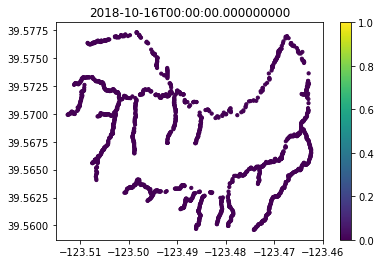

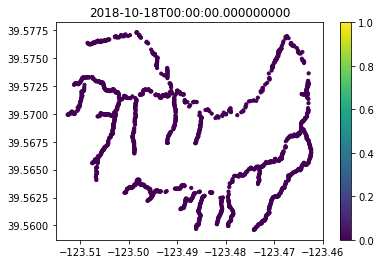

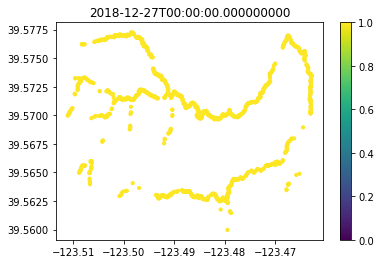

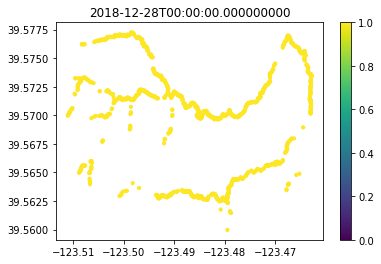

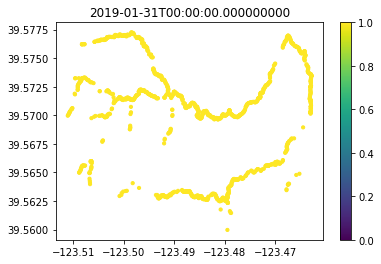

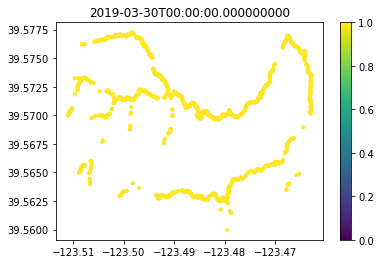

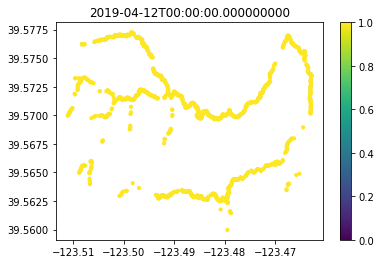

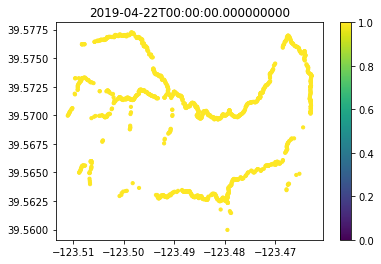

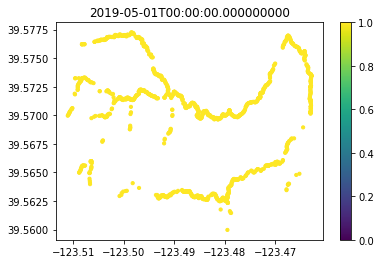

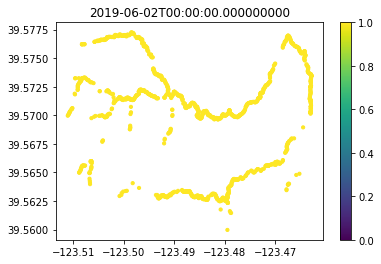

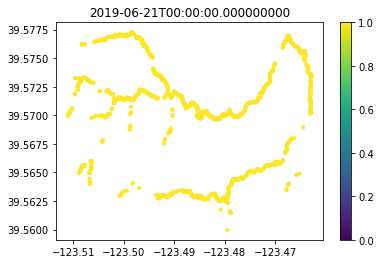

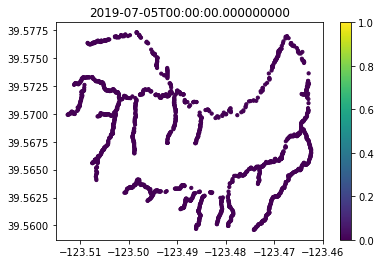

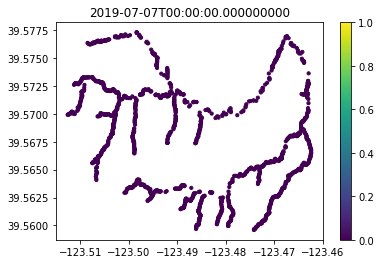

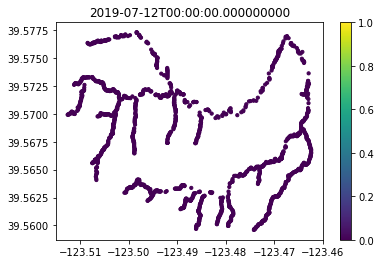

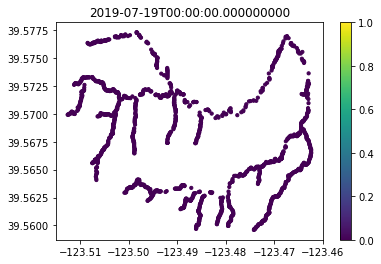

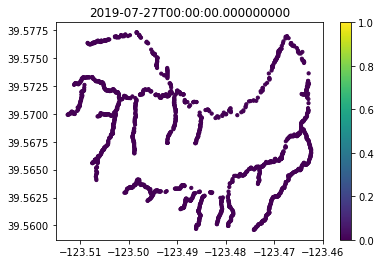

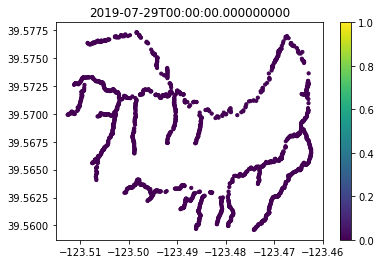

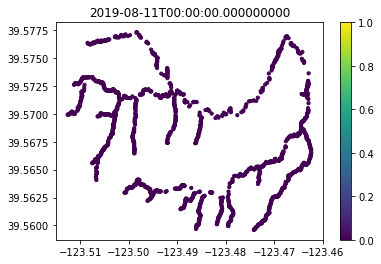

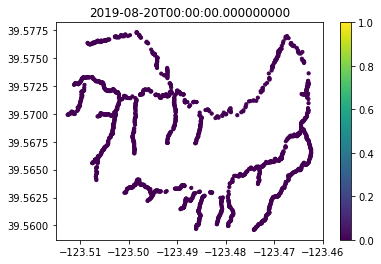

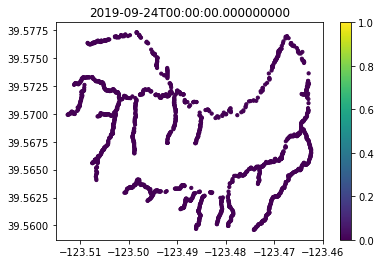

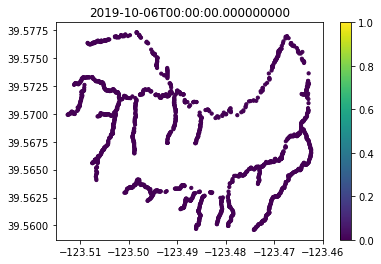

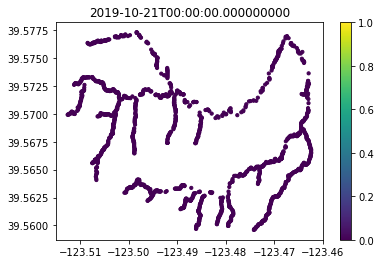

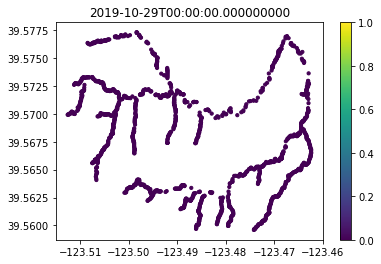

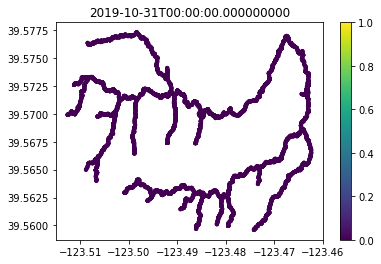

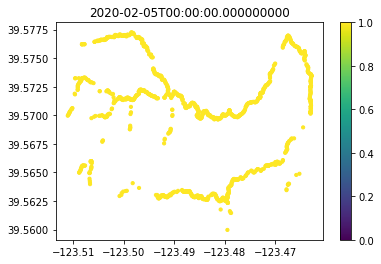

In [ ]:
added_data['date'] = pd.to_datetime(added_data.date)

%matplotlib inline
for date in added_data.date.sort_values().unique():
  plotdata = added_data[(added_data.date==date) &
                        (added_data.area_updated>100000)]
  plt.figure()
  plt.scatter(plotdata.x,plotdata.y,c=plotdata.wet,vmin=0,vmax=1,
              s = 10)
  plt.colorbar()
  plt.title(date)
  plt.show()